<!-- docusaurus_head_meta::start
---
title: Leaderboard Quickstart
---
docusaurus_head_meta::end -->

<!--- @wandbcode{leaderboard-demo} -->

# Leaderboard Quickstart

In this notebook we will learn to use Weave's Leaderboard to compare model performance across different datasets and scoring functions. Specifically, we will:

1. Generate a dataset of fake zip code data
2. Author some scoring functions and evaluate a baseline model.
3. Use these techniques to evaluate a matrix of models vs evaluations.
4. Review the leaderboard in the Weave UI.

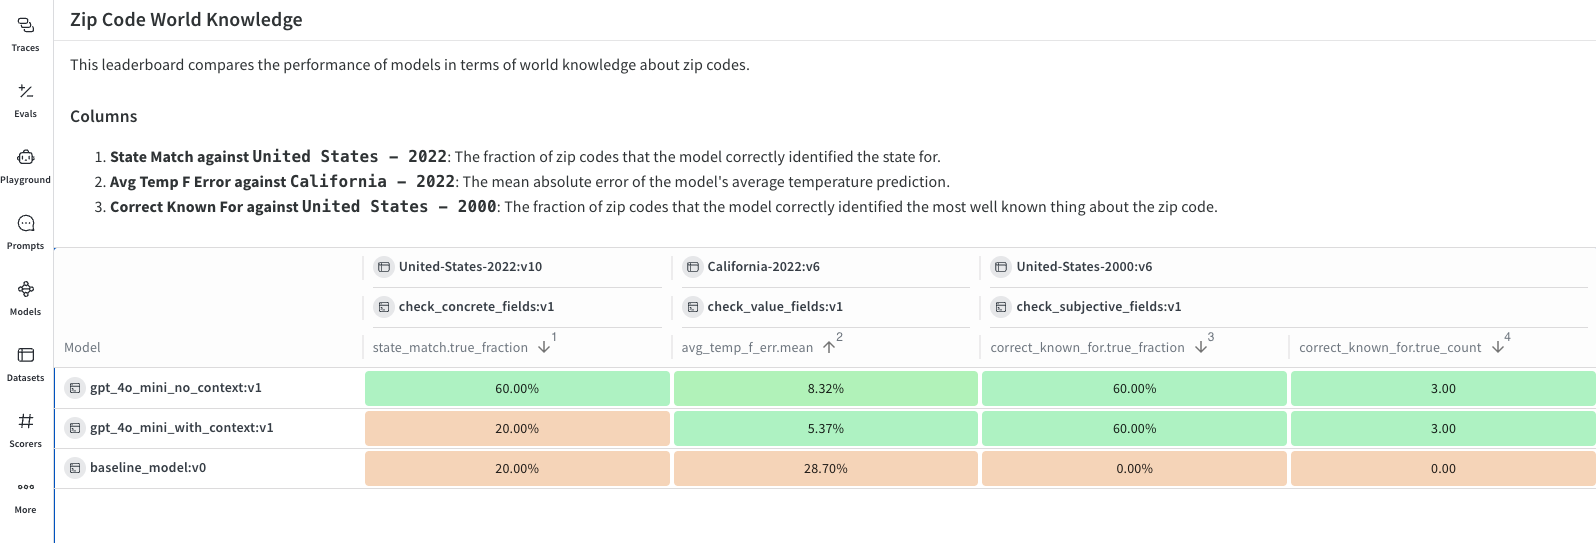



## Step 1: Generate a dataset of fake zip code data

First we will create a function `generate_dataset_rows` that generates a list of fake zip code data.

In [2]:
import json

from openai import OpenAI
from pydantic import BaseModel


class Row(BaseModel):
    zip_code: str
    city: str
    state: str
    avg_temp_f: float
    population: int
    median_income: int
    known_for: str


class Rows(BaseModel):
    rows: list[Row]


def generate_dataset_rows(
    location: str = "United States", count: int = 5, year: int = 2022
):
    client = OpenAI()

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"Please generate {count} rows of data for random zip codes in {location} for the year {year}.",
            },
        ],
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "response_format",
                "schema": Rows.model_json_schema(),
            },
        },
    )

    return json.loads(completion.choices[0].message.content)["rows"]

In [1]:
import weave

weave.init("leaderboard-demo")

## Step 2: Author scoring functions

Next we will author 3 scoring functions:

1. `check_concrete_fields`: Checks if the model output matches the expected city and state.
2. `check_value_fields`: Checks if the model output is within 10% of the expected population and median income.
3. `check_subjective_fields`: Uses a LLM to check if the model output matches the expected "known for" field.


In [3]:
@weave.op
def check_concrete_fields(city: str, state: str, output: dict):
    return {
        "city_match": city == output["city"],
        "state_match": state == output["state"],
    }


@weave.op
def check_value_fields(
    avg_temp_f: float, population: int, median_income: int, output: dict
):
    return {
        "avg_temp_f_err": abs(avg_temp_f - output["avg_temp_f"]) / avg_temp_f,
        "population_err": abs(population - output["population"]) / population,
        "median_income_err": abs(median_income - output["median_income"])
        / median_income,
    }


@weave.op
def check_subjective_fields(zip_code: str, known_for: str, output: dict):
    client = OpenAI()

    class Response(BaseModel):
        correct_known_for: bool

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"My student was asked what the zip code {zip_code} is best known best for. The right answer is '{known_for}', and they said '{output['known_for']}'. Is their answer correct?",
            },
        ],
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "response_format",
                "schema": Response.model_json_schema(),
            },
        },
    )

    return json.loads(completion.choices[0].message.content)

## Step 3: Create a simple Evaluation

Next we define a simple evaliation using our fake data and scoring functions.


In [4]:
rows = generate_dataset_rows()
evaluation = weave.Evaluation(
    name="United States - 2022",
    dataset=rows,
    scorers=[
        check_concrete_fields,
        check_value_fields,
        check_subjective_fields,
    ],
)

## Step 4: Evaluate a baseline model

Now we will evaluate a baseline model which returns a static response.


In [ ]:
@weave.op
def baseline_model(zip_code: str):
    return {
        "city": "New York",
        "state": "NY",
        "avg_temp_f": 50.0,
        "population": 1000000,
        "median_income": 100000,
        "known_for": "The Big Apple",
    }


await evaluation.evaluate(baseline_model)

## Step 5: Create more Models

Now we will create 2 more models to compare against the baseline.

In [ ]:
@weave.op
def gpt_4o_mini_no_context(zip_code: str):
    client = OpenAI()

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": f"""Zip code {zip_code}"""}],
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "response_format",
                "schema": Row.model_json_schema(),
            },
        },
    )

    return json.loads(completion.choices[0].message.content)


await evaluation.evaluate(gpt_4o_mini_no_context)

In [ ]:
@weave.op
def gpt_4o_mini_with_context(zip_code: str):
    client = OpenAI()

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": f"""Please answer the following questions about the zip code {zip_code}:
                   1. What is the city?
                   2. What is the state?
                   3. What is the average temperature in Fahrenheit?
                   4. What is the population?
                   5. What is the median income?
                   6. What is the most well known thing about this zip code?
                   """,
            }
        ],
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "response_format",
                "schema": Row.model_json_schema(),
            },
        },
    )

    return json.loads(completion.choices[0].message.content)


await evaluation.evaluate(gpt_4o_mini_with_context)

## Step 6: Create more Evaluations

Now we will evaluate a matrix of models vs evaluations.


In [ ]:
scorers = [
    check_concrete_fields,
    check_value_fields,
    check_subjective_fields,
]
evaluations = [
    weave.Evaluation(
        name="United States - 2022",
        dataset=weave.Dataset(
            name="United States - 2022",
            rows=generate_dataset_rows("United States", 5, 2022),
        ),
        scorers=scorers,
    ),
    weave.Evaluation(
        name="California - 2022",
        dataset=weave.Dataset(
            name="California - 2022", rows=generate_dataset_rows("California", 5, 2022)
        ),
        scorers=scorers,
    ),
    weave.Evaluation(
        name="United States - 2000",
        dataset=weave.Dataset(
            name="United States - 2000",
            rows=generate_dataset_rows("United States", 5, 2000),
        ),
        scorers=scorers,
    ),
]
models = [
    baseline_model,
    gpt_4o_mini_no_context,
    gpt_4o_mini_with_context,
]

for evaluation in evaluations:
    for model in models:
        await evaluation.evaluate(
            model, __weave={"display_name": evaluation.name + ":" + model.__name__}
        )

## Step 7: Review the Leaderboard

You can create a new leaderboard by navigating to the leaderboard tab in the UI and clicking "Create Leaderboard".

We can also generate a leaderboard directly from Python:

In [9]:
from weave.flow import leaderboard
from weave.trace.weave_client import get_ref

spec = leaderboard.Leaderboard(
    name="Zip Code World Knowledge",
    description="""
This leaderboard compares the performance of models in terms of world knowledge about zip codes.

### Columns

1. **State Match against `United States - 2022`**: The fraction of zip codes that the model correctly identified the state for.
2. **Avg Temp F Error against `California - 2022`**: The mean absolute error of the model's average temperature prediction.
3. **Correct Known For against `United States - 2000`**: The fraction of zip codes that the model correctly identified the most well known thing about the zip code.
""",
    columns=[
        leaderboard.LeaderboardColumn(
            evaluation_object_ref=get_ref(evaluations[0]).uri(),
            scorer_name="check_concrete_fields",
            summary_metric_path="state_match.true_fraction",
        ),
        leaderboard.LeaderboardColumn(
            evaluation_object_ref=get_ref(evaluations[1]).uri(),
            scorer_name="check_value_fields",
            should_minimize=True,
            summary_metric_path="avg_temp_f_err.mean",
        ),
        leaderboard.LeaderboardColumn(
            evaluation_object_ref=get_ref(evaluations[2]).uri(),
            scorer_name="check_subjective_fields",
            summary_metric_path="correct_known_for.true_fraction",
        ),
    ],
)

ref = weave.publish(spec)

📦 Published to https://wandb.ai/timssweeney/leaderboard-demo/weave/leaderboards/Zip-Code-World-Knowledge
